In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import furniture_bench
from furniture_bench.envs.furniture_sim_env import FurnitureSimEnv
import os
from pathlib import Path

import torch
import zarr

import numpy as np
import matplotlib.pyplot as plt

from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    unpickle_data,
    mp4_from_data_dict_jupyter,
    create_mp4_jupyter,
)
from src.common.geometry import action_to_6d_rotation
from src.data_processing.utils import resize, resize_crop

from tqdm import trange, tqdm

from src.gym import get_env

In [3]:
env: FurnitureSimEnv = get_env(
    furniture="one_leg",
    num_envs=1,
    gpu_id=0,
    act_rot_repr="rot_6d",
    ctrl_mode="osc",
    randomness="low",
    resize_img=False,
)

In [4]:
tmp_dir = Path("tmp_rollout_dir")

In [5]:
scripted_dir = (
    Path(os.environ["DATA_DIR_RAW"])
    / "raw"
    / "sim"
    / "one_leg"
    / "scripted"
    / "low"
    / "success"
)

scripted_pickles = list(scripted_dir.glob("*.pkl*"))

print("Found ", len(scripted_pickles))

scripted_data = [unpickle_data(p) for p in scripted_pickles[:5]]

Found  250


In [6]:
def env_replay(env, data, max_len=1_000):
    # Play them back in the simulator
    for i, data in enumerate(data[:5]):
        # Reset the env
        env.reset()

        # Cut of the trajectory at max_len
        actions = np.array(data["actions"][:max_len])
        max_len = (
            actions.shape[0] if max_len is None else min(max_len, actions.shape[0])
        )
        observations = data["observations"][:max_len]

        # Set the initial state
        env.reset_env_to(env_idx=0, state=observations[0])

        # Play back the actions in the trajectory
        imgs1 = []
        imgs2 = []

        action = action_to_6d_rotation(torch.tensor(actions).cuda())

        for i in trange(len(actions)):
            obs, reward, done, info = env.step(action[i : i + 1])
            imgs1.append(resize(obs["color_image1"]).squeeze().cpu().numpy())
            imgs2.append(resize_crop(obs["color_image2"]).squeeze().cpu().numpy())

        # See the scripted and the replay side-by-side
        ims2_s = np.array([o["color_image2"] for o in observations])
        ims2_r = np.array(imgs2)

        print(ims2_s.shape, ims2_r.shape)

        ims_sbs = np.concatenate([ims2_s, ims2_r], axis=2)

        create_mp4_jupyter(ims_sbs, tmp_dir / f"replay{i}.mp4")

### Look at teleop data

In [7]:
teleop_dir = (
    Path(os.environ["DATA_DIR_RAW"])
    / "raw"
    / "sim"
    / "square_table"
    / "teleop"
    / "low"
    / "success"
)

teleop_pickles = list(teleop_dir.glob("*.pkl*"))

print("Found ", len(teleop_pickles))

teleop_data = [unpickle_data(p) for p in tqdm(teleop_pickles[:10])]

Found  1


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


In [8]:
env_replay(env, teleop_data[:5], max_len=600)

INFO: Found collision-free init pose
  0%|          | 1/600 [00:00<01:00,  9.92it/s]

square_table_top (id: 0), square_table_leg4 (id: 4) are assembled.
Assembled Set
[square_table_top (id: 0), square_table_leg4 (id: 4)] 


100%|██████████| 600/600 [00:29<00:00, 20.31it/s]


(600, 240, 320, 3) (600, 240, 320, 3)
File saved as tmp_rollout_dir/replay599.mp4


In [17]:
# import pca and plot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Make interactive 3D plot of xyz actions
from mpl_toolkits.mplot3d import Axes3D

In [33]:
actions_scripted = np.concatenate([d["actions"] for d in scripted_data])
actions_teleop = np.concatenate([d["actions"] for d in teleop_data])
actions = np.concatenate([actions_scripted, actions_teleop])

labels = np.concatenate(
    [np.zeros(len(actions_scripted)), np.ones(len(actions_teleop))]
).astype(int)
colors = [["C0", "C1"][l] for l in labels]

actions_scripted.shape, actions_teleop.shape

((3138, 8), (668, 8))

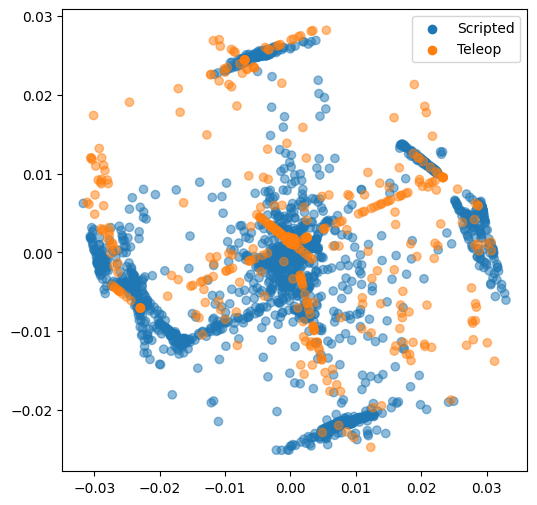

In [32]:
# PCA
pca_xyz = PCA(n_components=2)
xyz_components = pca_xyz.fit_transform(actions[:, :3])

# plot


fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(
    xyz_components[:, 0],
    xyz_components[:, 1],
    c=,
    alpha=0.5,
)

# Add legend
ax.scatter([], [], c="C0", label="Scripted")
ax.scatter([], [], c="C1", label="Teleop")
ax.legend()

Text(0.5, 0, 'Z')

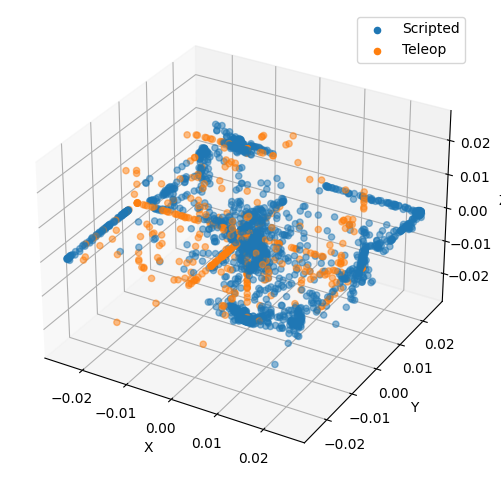

In [35]:
# Make interactive 3D plot of xyz actions
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    actions[:, 0],
    actions[:, 1],
    actions[:, 2],
    c=colors,
    alpha=0.5,
)

# Add legend
ax.scatter([], [], c="C0", label="Scripted")
ax.scatter([], [], c="C1", label="Teleop")
ax.legend()

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

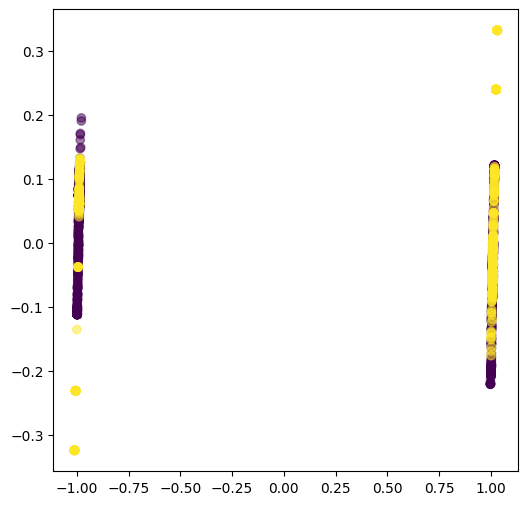

In [13]:
# Do PCA for the angles
pca_angles = PCA(n_components=2)
angles_components = pca_angles.fit_transform(actions[:, 3:8])

# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(
    angles_components[:, 0],
    angles_components[:, 1],
    c=labels,
    alpha=0.5,
)

## Look at the processed data to sanity check

In [9]:
z = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/one_leg/scripted/success.zarr",
    mode="r",
)
list(z.keys())

['action',
 'color_image1',
 'color_image2',
 'episode_ends',
 'feature',
 'furniture',
 'parts_poses',
 'pickle_file',
 'reward',
 'robot_state',
 'skill',
 'success']

In [10]:
z["color_image1"].shape, z["color_image2"].shape, z["action/delta"].shape

((245693, 240, 320, 3), (245693, 240, 320, 3), (245693, 10))